In [1]:
import pandas as pd
import numpy as np
import re
import emoji
from time import time


from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.corpus import stopwords
from textblob import Word
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib


import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)


In [4]:
# Importing the dataset
data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

In [5]:
data.shape

(1000, 2)

In [6]:
data

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1
...,...,...
995,I think food should have flavor and texture and both were lacking.,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go back.,0
998,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [8]:
#Renaming columns as 'Serial No','Text','Emotion'
data.columns=['text','Emotion']

In [9]:
data

,text,Emotion
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1
4,The selection on the menu was great and so were the prices.,1
...,...,...
995,I think food should have flavor and texture and both were lacking.,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go back.,0
998,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0


In [10]:
data.Emotion.value_counts()

1    500
0    500
Name: Emotion, dtype: int64

In [11]:
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

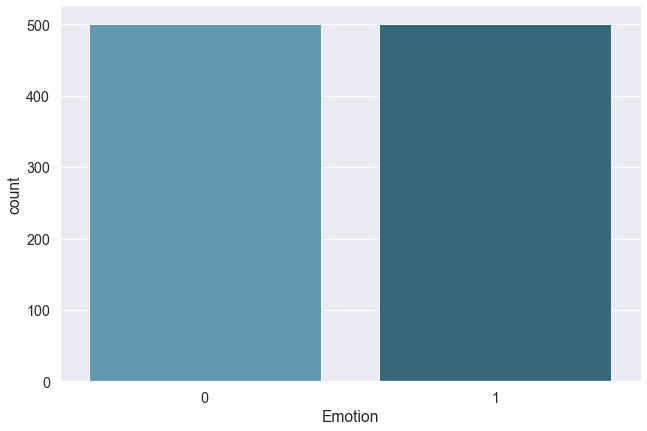

In [12]:
target_dist = sns.factorplot(x="Emotion", data=data, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

In [13]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [14]:
tc = TextCounts()
df_eda = tc.fit_transform(data.text)


In [15]:
df_eda

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,4,0,0,0,0,0,0
1,4,0,0,0,0,0,0
2,8,0,0,0,0,0,0
3,15,0,0,0,0,0,0
4,12,0,0,0,0,0,0
...,...,...,...,...,...,...,...
995,12,0,0,0,0,0,0
996,3,0,0,0,0,0,0
997,10,0,0,0,0,0,0
998,17,0,0,0,0,0,0


In [16]:
df_eda['Emotion'] = data.Emotion

In [17]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('Emotion')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='Emotion', size=5, hue='Emotion', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
         count    mean       std  min  25%   50%    75%   max
Emotion                                                      
0        500.0  11.798  6.759036  2.0  6.0  10.0  16.25  32.0
1        500.0  10.430  5.903457  1.0  6.0  9.0   14.00  31.0


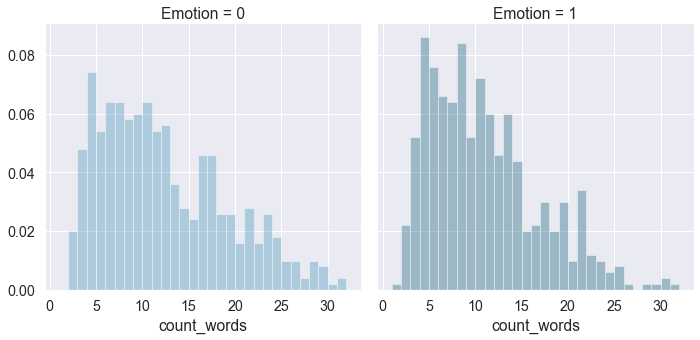

In [18]:
show_dist(df_eda, 'count_words')

Descriptive stats for count_capital_words
-----------------------------------------
         count   mean       std  min  25%  50%  75%   max
Emotion                                                  
0        500.0  0.128  0.795539  0.0  0.0  0.0  0.0  13.0
1        500.0  0.064  0.268418  0.0  0.0  0.0  0.0  2.0 


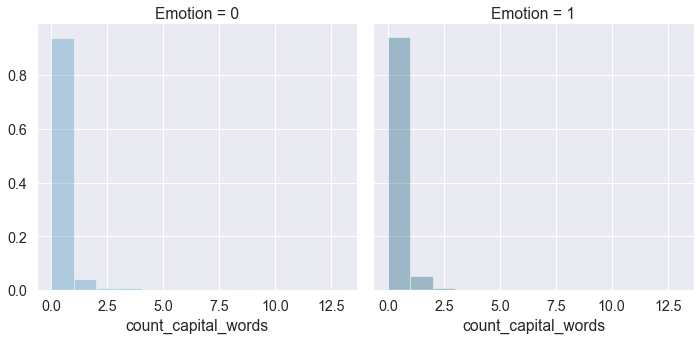

In [19]:
show_dist(df_eda, 'count_capital_words')

In [20]:
data.text

0      Wow... Loved this place.                                                                                                              
1      Crust is not good.                                                                                                                    
2      Not tasty and the texture was just nasty.                                                                                             
3      Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.                                               
4      The selection on the menu was great and so were the prices.                                                                           
                                  ...                                                                                                        
995    I think food should have flavor and texture and both were lacking.                                                                    
996   

In [21]:
import string  
    
# Storing the sets of punctuation in variable result  
result = string.punctuation  
    
# Printing the punctuation values  
print(result)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
     
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [23]:
ct = CleanText()
sr_clean = ct.fit_transform(data.text)
sr_clean.sample(5)

982    food averag      
697    mortifi          
11     would not go back
604    ask satisfi meal 
647    food averag best 
Name: text, dtype: object

In [24]:
sr_clean.head()


0    wow love place                                      
1    crust not good                                      
2    not tasti textur nasti                              
3    stop late may bank holiday rick steve recommend love
4    select menu great price                             
Name: text, dtype: object

In [25]:
empty_clean = sr_clean == ''
empty_clean

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: text, Length: 1000, dtype: bool

In [26]:
sr_clean[empty_clean].count()

1

In [27]:
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

1 records have no words left after text cleaning


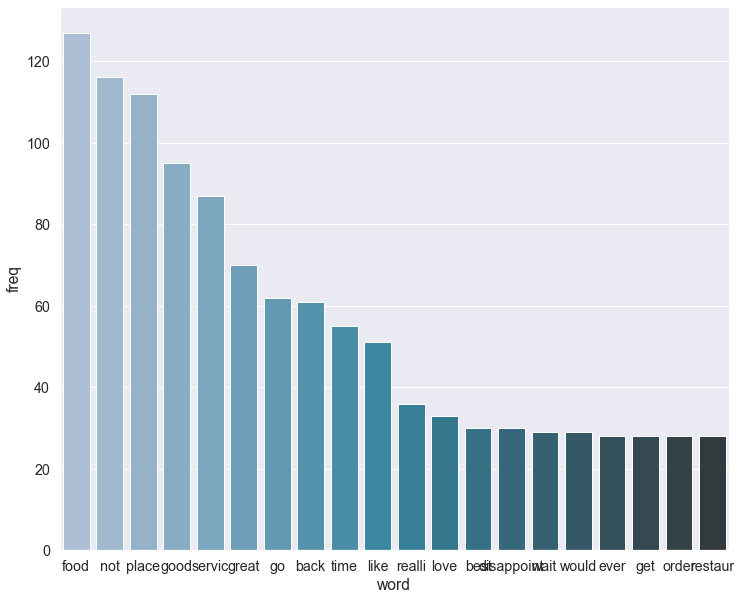

In [28]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();


In [29]:
df_model = df_eda
df_model['clean_text'] = sr_clean
df_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'Emotion',
 'clean_text']

In [30]:
df_model

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,Emotion,clean_text
0,4,0,0,0,0,0,0,1,wow love place
1,4,0,0,0,0,0,0,0,crust not good
2,8,0,0,0,0,0,0,0,not tasti textur nasti
3,15,0,0,0,0,0,0,1,stop late may bank holiday rick steve recommend love
4,12,0,0,0,0,0,0,1,select menu great price
...,...,...,...,...,...,...,...,...,...
995,12,0,0,0,0,0,0,0,think food flavor textur lack
996,3,0,0,0,0,0,0,0,appetit instantli gone
997,10,0,0,0,0,0,0,0,overal not impress would not go back
998,17,0,0,0,0,0,0,0,whole experi underwhelm think go ninja sushi next time


In [31]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Emotion', axis=1), df_model.Emotion, test_size=0.1, random_state=37)

In [33]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [34]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [35]:
mnb = MultinomialNB()
logreg = LogisticRegression()

In [36]:
countvect = CountVectorizer()

In [37]:
# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s


done in 6.699s

Best CV score: 0.799
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.830


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        42
           1       0.92      0.78      0.84        58

    accuracy                           0.83       100
   macro avg       0.83      0.84      0.83       100
weighted avg       0.85      0.83      0.83       100



[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    6.5s finished


In [38]:
# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    2.5s


done in 5.867s

Best CV score: 0.804
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.810


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.71      0.93      0.80        42
           1       0.93      0.72      0.82        58

    accuracy                           0.81       100
   macro avg       0.82      0.83      0.81       100
weighted avg       0.84      0.81      0.81       100



[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    5.6s finished


In [39]:
tfidfvect = TfidfVectorizer()

In [40]:
# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s


done in 3.416s

Best CV score: 0.781
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.860


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.77      0.95      0.85        42
           1       0.96      0.79      0.87        58

    accuracy                           0.86       100
   macro avg       0.86      0.87      0.86       100
weighted avg       0.88      0.86      0.86       100



[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.3s finished


In [41]:
# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s


done in 5.540s

Best CV score: 0.793
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.820


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.72      0.93      0.81        42
           1       0.93      0.74      0.83        58

    accuracy                           0.82       100
   macro avg       0.83      0.83      0.82       100
weighted avg       0.85      0.82      0.82       100



[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    5.4s finished


In [42]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\SHUBHAM
[nltk_data]     SHARMA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
SIZE = 25

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
                 , min_count=1
                 , size=SIZE
                 , window=3
                 , workers=4)

In [44]:
model.most_similar('food', topn=3)

[('drastic', 0.5682830810546875),
 ('foot', 0.5552674531936646),
 ('genuin', 0.5450969934463501)]

In [45]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return result

In [46]:
X_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [47]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)

# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [48]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


done in 0.619s

Best CV score: 0.551
Best parameters set:
	clf__C: 0.5
	clf__penalty: 'l2'
Test score with best_estimator_: 0.620


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.54      0.64      0.59        42
           1       0.70      0.60      0.65        58

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.63      0.62      0.62       100



[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


In [49]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                         , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1.0, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('Emotion', axis=1), df_model.Emotion)

In [50]:
new_negative_tweets = pd.Series(["A very nice restaurant, excellent service, high quality food"
                      ,"Bad restaurant, bad experience "
                      ,"A example of a very bad restaurant "])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()

[1, 0, 0]

In [51]:
new_negative_tweets = pd.Series([" Food quality average but prices are high. Even ambience is not good"
                      ,"I've been to countless brunches in the past, but not to a dedicated all Italian brunch. Last Sunday I was hosted by Bene at Sheraton Grand Bangalore Hotel - Brigade Gateway. Chef Roberto Apa and team showcased the best of authentic Italian cuisine. Buffet spread featured handmade raviolis, artisanal breads, wood fire pizza, smoked meats and classic Italian desserts. I highly recommend a visit if you enjoy italian cuisine like me. "
                      ,"I think food  had flavor and texture and both were terrible."
                                ])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

test_list=best_model.predict(df_model_neg).tolist()
test_list

[0, 1, 0]

In [52]:
# initializing list 

  
# Printing list  
print ("Original list is : " + str(test_list)) 
  
# using naive method to 
# get index and value 
print ("List index-value are : ") 
for i in range(len(test_list)):
    if test_list[i] == 0:
           print("BAD")
    else:
        print("GOOD")     

Original list is : [0, 1, 0]
List index-value are : 
BAD
GOOD
BAD


In [53]:
 from sklearn.linear_model import RidgeClassifier

In [54]:
textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
features = FeatureUnion([
                         ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                           , ('vect', CountVectorizer(max_df=0.5, min_df=1, ngram_range=(1,2)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', RidgeClassifier())
])

best_model = pipeline.fit(df_model.drop('Emotion', axis=1), df_model.Emotion)

In [63]:
new_negative_tweets = pd.Series(["A very nice restaurant, excellent service, high quality food"
                      ,"Bad restaurant, bad experience "
                      ,"A example of a very bad restaurant "])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()



[1, 0, 0]

In [65]:
new_negative_tweets = pd.Series(["The food quality is very very bad had order some soup it was so terrible could eat more than a spoonful. They need to change the chef at the earliest. The service and ambiance is okay."
                      ,"Bad food quality, wastage of money, we can get better food in the other hotels ,service was also not good. "
                      ,"We had three meals in this restaurant. We found the food to be very spicy but it was very tasty. There is no issue with the quality of the food. They had buffet but it had only vegetarian. All in all a good place to have your lunch or dinner here"])

df_counts_neg = tc.transform(new_negative_tweets)
df_clean_neg = ct.transform(new_negative_tweets)
df_model_neg = df_counts_neg
df_model_neg['clean_text'] = df_clean_neg

best_model.predict(df_model_neg).tolist()



[0, 0, 1]